In [1]:
# Electricity Load Forecasting - Exploratory Data Analysis (EDA)

# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the Excel file
file_path = "../data/train_dataframes.xlsx"  # Change this to your file path
xls = pd.ExcelFile(file_path)

# Load a subset of sheets (first 5) for efficient analysis
selected_sheets = xls.sheet_names[:5]
df_list = [pd.read_excel(xls, sheet_name=sheet) for sheet in selected_sheets]
df = pd.concat(df_list, ignore_index=True)

# Convert datetime column to proper format
df["datetime"] = pd.to_datetime(df["datetime"])

# Display first few rows
df.head()


,datetime,week_X-2,week_X-3,week_X-4,MA_X-4,dayOfWeek,weekend,holiday,Holiday_ID,hourOfDay,T2M_toc,DEMAND
0,2015-01-31 01:00:00,962.2865,906.9580,970.3450,938.004850,1,1,0,0,1,25.308496,954.2018
1,2015-01-31 02:00:00,933.3221,863.5135,912.1755,900.284075,1,1,0,0,2,25.141443,913.8660
2,2015-01-31 03:00:00,903.9817,848.4447,900.2688,881.704325,1,1,0,0,3,25.006738,903.3637
3,2015-01-31 04:00:00,900.9995,839.8821,889.9538,876.458825,1,1,0,0,4,24.899713,889.0806
4,2015-01-31 05:00:00,904.3481,847.1073,893.6865,879.190775,1,1,0,0,5,24.821558,910.1472


In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Load the dataset
file_path = "../data/train_dataframes.xlsx"  # Change this path
xls = pd.ExcelFile(file_path)

# Load selected sheets (first 5 to optimize performance)
selected_sheets = xls.sheet_names[:5]
df_list = [pd.read_excel(xls, sheet_name=sheet) for sheet in selected_sheets]
df = pd.concat(df_list, ignore_index=True)

# Convert datetime column to datetime type
df["datetime"] = pd.to_datetime(df["datetime"])
df.set_index("datetime", inplace=True)

# Display basic info
df.info()
df.head()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 191496 entries, 2015-01-31 01:00:00 to 2019-08-14 00:00:00
Data columns (total 11 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   week_X-2    191496 non-null  float64
 1   week_X-3    191496 non-null  float64
 2   week_X-4    191496 non-null  float64
 3   MA_X-4      191496 non-null  float64
 4   dayOfWeek   191496 non-null  int64  
 5   weekend     191496 non-null  int64  
 6   holiday     191496 non-null  int64  
 7   Holiday_ID  191496 non-null  int64  
 8   hourOfDay   191496 non-null  int64  
 9   T2M_toc     191496 non-null  float64
 10  DEMAND      191496 non-null  float64
dtypes: float64(6), int64(5)
memory usage: 17.5 MB


,week_X-2,week_X-3,week_X-4,MA_X-4,dayOfWeek,weekend,holiday,Holiday_ID,hourOfDay,T2M_toc,DEMAND
datetime,,,,,,,,,,,
2015-01-31 01:00:00,962.2865,906.9580,970.3450,938.004850,1,1,0,0,1,25.308496,954.2018
2015-01-31 02:00:00,933.3221,863.5135,912.1755,900.284075,1,1,0,0,2,25.141443,913.8660
2015-01-31 03:00:00,903.9817,848.4447,900.2688,881.704325,1,1,0,0,3,25.006738,903.3637
2015-01-31 04:00:00,900.9995,839.8821,889.9538,876.458825,1,1,0,0,4,24.899713,889.0806
2015-01-31 05:00:00,904.3481,847.1073,893.6865,879.190775,1,1,0,0,5,24.821558,910.1472


In [3]:
# Create lag features (important lags based on ACF/PACF)
for lag in [1, 7, 14, 21, 28]:
    df[f"lag_{lag}"] = df["DEMAND"].shift(lag)

# Create rolling statistics (3-day, 7-day, 14-day moving averages)
df["rolling_mean_3"] = df["DEMAND"].rolling(window=3, min_periods=1).mean()
df["rolling_mean_7"] = df["DEMAND"].rolling(window=7, min_periods=1).mean()
df["rolling_mean_14"] = df["DEMAND"].rolling(window=14, min_periods=1).mean()

# Optionally: create rolling std deviation (helps in volatile demand)
df["rolling_std_7"] = df["DEMAND"].rolling(window=7, min_periods=1).std()

# Time-based features
df["hour"] = df.index.hour
df["dayofweek"] = df.index.dayofweek
df["month"] = df.index.month
df["is_weekend"] = df["dayofweek"].isin([5, 6]).astype(int)  # New feature

# Drop NaN values generated by lagging
df.dropna(inplace=True)

# Display updated data
df.head()


,week_X-2,week_X-3,week_X-4,MA_X-4,dayOfWeek,weekend,holiday,Holiday_ID,hourOfDay,T2M_toc,...,lag_21,lag_28,rolling_mean_3,rolling_mean_7,rolling_mean_14,rolling_std_7,hour,dayofweek,month,is_weekend
datetime,,,,,,,,,,,,,,,,,,,,,
2015-02-01 05:00:00,815.4005,842.7522,884.6659,834.463400,2,1,0,0,5,25.043604,...,1077.8575,954.2018,859.554733,899.297300,990.348871,49.740936,5,6,2,1
2015-02-01 06:00:00,785.2751,807.4211,862.9888,810.501925,2,1,0,0,6,25.096826,...,1179.6601,913.8660,842.977867,875.539257,971.814971,38.422319,6,6,2,1
2015-02-01 07:00:00,784.1150,813.1819,871.6873,815.810325,2,1,0,0,7,26.019800,...,1255.1569,903.3637,836.889000,861.114386,955.650414,27.911603,7,6,2,1
2015-02-01 08:00:00,850.1076,873.8010,912.4966,867.222075,2,1,0,0,8,27.205042,...,1253.4414,889.0806,853.417633,860.408843,941.640557,26.670768,8,6,2,1
2015-02-01 09:00:00,900.5203,935.3192,969.8017,925.125075,2,1,0,0,9,28.295648,...,1223.6116,910.1472,901.311667,872.123600,930.875036,48.117779,9,6,2,1


In [4]:
import pandas as pd

# Load your train and test datasets
train_df = df.copy()  # Assuming your feature-engineered training df is already named df
test_df = pd.read_excel("../data/test_dataframes.xlsx")

# Ensure datetime is correctly set
if "datetime" in test_df.columns:
    test_df["datetime"] = pd.to_datetime(test_df["datetime"])
    test_df.set_index("datetime", inplace=True)

# -------------------------
# Feature Engineering - Must be SAME for both train and test
# -------------------------

# Lags
for lag in [1, 7, 14, 21, 28]:
    train_df[f"lag_{lag}"] = train_df["DEMAND"].shift(lag)
    test_df[f"lag_{lag}"] = test_df["DEMAND"].shift(lag)

# Rolling means and std
for window in [3, 7, 14]:
    train_df[f"rolling_mean_{window}"] = train_df["DEMAND"].rolling(window=window).mean()
    test_df[f"rolling_mean_{window}"] = test_df["DEMAND"].rolling(window=window).mean()

train_df["rolling_std_7"] = train_df["DEMAND"].rolling(window=7).std()
test_df["rolling_std_7"] = test_df["DEMAND"].rolling(window=7).std()

# Time-based features
for df_ in [train_df, test_df]:
    df_["hour"] = df_.index.hour
    df_["dayofweek"] = df_.index.dayofweek
    df_["month"] = df_.index.month
    df_["is_weekend"] = df_.index.dayofweek.isin([5, 6]).astype(int)

# -------------------------
# Drop NaNs generated by rolling/lags
# -------------------------
train_df.dropna(inplace=True)
test_df.dropna(inplace=True)

# -------------------------
# Create X_train, y_train, and X_test
# -------------------------
TARGET = "DEMAND"

features = [col for col in train_df.columns if col != TARGET]

X_train = train_df[features]
y_train = train_df[TARGET]

X_test = test_df[features]  # Same features as training
y_test = test_df['DEMAND']

# Confirm shape
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")



X_train shape: (191440, 23)
y_train shape: (191440,)
X_test shape: (140, 23)


In [5]:
from tensorflow.keras.layers import GRU
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import  Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt

# Prepare data for GRU
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
y_train_scaled = scaler.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler.transform(y_test.values.reshape(-1, 1))

time_step = 60  # Number of previous time steps to use for prediction
X_train_gru, y_train_gru = create_dataset(y_train_scaled, time_step)
X_test_gru, y_test_gru = create_dataset(y_test_scaled, time_step)

# Reshape data for GRU input
X_train_lstm = X_train_gru.reshape(X_train_gru.shape[0], X_train_gru.shape[1], 1)
X_test_lstm = X_test_gru.reshape(X_test_gru.shape[0], X_test_gru.shape[1], 1)

# Build GRU model
model_gru = Sequential()
model_gru.add(GRU(units=50, return_sequences=True, input_shape=(time_step, 1)))
model_gru.add(Dropout(0.2))
model_gru.add(GRU(units=50, return_sequences=False))
model_gru.add(Dropout(0.2))
model_gru.add(Dense(units=1))

# Compile and fit the model
model_gru.compile(optimizer='adam', loss='mean_squared_error')
model_gru.fit(X_train_gru, y_train_gru, epochs=2, batch_size=32)

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/2
5981/5981 ━━━━━━━━━━━━━━━━━━━━ 194s 31ms/step - loss: 0.0063
Epoch 2/2
5981/5981 ━━━━━━━━━━━━━━━━━━━━ 169s 28ms/step - loss: 7.3528e-04


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 732ms/step
GRU - Mean Absolute Error (MAE): 23.22
GRU - Root Mean Squared Error (RMSE): 29.34


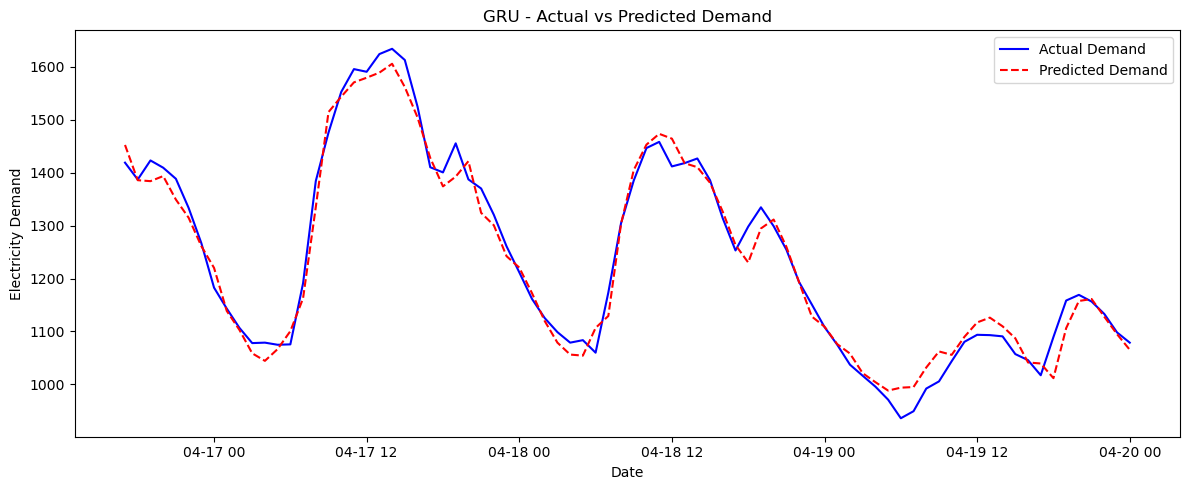

In [6]:
# Make predictions
predicted_demand_gru = model_gru.predict(X_test_lstm)

# Inverse transform predictions and actual values
predicted_demand_gru = scaler.inverse_transform(predicted_demand_gru)
y_test_actual_gru = scaler.inverse_transform(y_test_gru.reshape(-1, 1))

# Evaluate the model (MAE, RMSE)
mae_gru = mean_absolute_error(y_test_actual_gru, predicted_demand_gru)
rmse_gru = np.sqrt(mean_squared_error(y_test_actual_gru, predicted_demand_gru))

print(f"GRU - Mean Absolute Error (MAE): {mae_gru:.2f}")
print(f"GRU - Root Mean Squared Error (RMSE): {rmse_gru:.2f}")

# Plot the results
aligned_index = y_test.index[time_step:]  # shift by 60

plt.figure(figsize=(12, 5))
plt.plot(aligned_index, y_test_actual_gru, label="Actual Demand", color="blue")
plt.plot(aligned_index, predicted_demand_gru, label="Predicted Demand", color="red", linestyle="dashed")
plt.xlabel("Date")
plt.ylabel("Electricity Demand")
plt.title("GRU - Actual vs Predicted Demand")
plt.legend()
plt.tight_layout()
plt.show()


In [7]:
import os

# Create the folder if it doesn't exist
os.makedirs("../model_weights", exist_ok=True)

# Save the GRU model in HDF5 format
model_gru.save("../model_weights/gru_model.h5")

print("GRU model saved at '../model_weights/gru_model.h5'")


GRU model saved at '../model_weights/gru_model.h5'


In [8]:
from tensorflow.keras.models import load_model

# Load the saved GRU model
loaded_gru_model = load_model("../model_weights/gru_model.h5")

# Example usage
# predictions = loaded_gru_model.predict(X_test_gru)
